# Recipe Site Traffic

Tasty Bytes is a growing subscription-based meal planning and delivery company that started as a recipe search engine during the pandemic. Now, they're looking to use data science to improve homepage recipe selection—specifically, to predict which recipes will drive high traffic and increase subscriptions. My task is to develop a model that can accurately identify popular recipes, with a target of at least 80% prediction accuracy.

## Data Validation
This data set has 947 rows, 8 columns. I have validated all variables and I have made changes after validation. All the columns are just as described in the data dictionary:

- recipe: 947 recipes without missing values, same as the description. No cleaning is needed.
- calories: 52 missing values, corresponding to 5% of the dataset. I opted to drop these rows.
- carbohydrate: 52 missing values, corresponding to 5% of the dataset. I opted to drop these rows.
- sugar: 52 missing values, corresponding to 5% of the dataset. I opted to drop these rows.
- protein: 52 missing values, corresponding to 5% of the dataset. I opted to drop these rows.
- category: 11 distinct categories with no missing values, rather than the 10 stated in the original description. I combined the "Chicken Breast" category with "Chicken," as they represent the same type of item.
- servings: 6 strings without missing values, Non-numeric entries ("4 as a snack", "6 as a snack") replaced with numeric values (3, 5) then converted to int.
- high_traffic: 373 missing values, NaN values converted to "Low", "High" = 1, "Low" = 0, binary column.

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("recipe_site_traffic_2212.csv")

# Make a copy to keep the original
df_clean = df.copy()
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None


In [148]:
df_clean.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [149]:
df_clean["recipe"].nunique()

947

In [150]:
print(df_clean["high_traffic"].isnull().sum())

# Ensure binary conversion (1="High", 0="Low" including NaN cases)
df_clean['high_traffic'] = df_clean['high_traffic'].fillna("Low")

print(df_clean['high_traffic'].unique())

373
['High' 'Low']


In [151]:
# Number of missing values
df_clean.isnull().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

In [152]:
# Rows have missing values
missing_values = df_clean[df_clean.isnull().any(axis=1)]

# Calculate percent of missing values
percent_missing = (missing_values.isnull().sum() / len(df_clean)) * 100
print(percent_missing)

recipe          0.000000
calories        5.491024
carbohydrate    5.491024
sugar           5.491024
protein         5.491024
category        0.000000
servings        0.000000
high_traffic    0.000000
dtype: float64


The missing values in calories, carbohydrate, sugar, and protein are all in the same rows, which account for only 5.5% of the dataset. Since this is a minimal portion, removing these rows is a reasonable step to maintain data integrity without significantly affecting the analysis.

In [153]:
# Remove rows have missing values
df_clean.dropna(axis=0,inplace=True)
df_clean.shape

(895, 8)

In [154]:
df_clean["category"].unique()

array(['Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Pork', 'Chicken', 'Vegetable',
       'Meat', 'Dessert'], dtype=object)

I combined the "Chicken Breast" category with "Chicken," as they represent the same type of item.

In [155]:
# Merge category Chicken Breast into Chicken
df_clean['category'] = df_clean['category'].replace('Chicken Breast', 'Chicken')

In [156]:
print(df_clean["servings"].unique())
df_clean["servings"] = df_clean["servings"].replace({'4 as a snack': '4', '6 as a snack': '6'}).astype(int)
print(df_clean["servings"].unique())

['4' '1' '2' '6' '4 as a snack' '6 as a snack']
[4 1 2 6]


In [157]:
# Validate any negative values in numeric variables
df_clean.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


In [158]:
# Check number of duplicate values
df_duplicates = df_clean.duplicated().sum()
df_duplicates

0

## Exploratory Analysis
I analyzed the target variable (high_traffic) and the features (calories, carbs, sugar, protein, servings, category) to understand their distributions and relationships. Based on the findings, I made the following adjustments to improve modeling:

- Calories, Carbohydrate, sugar and protein use log transformation

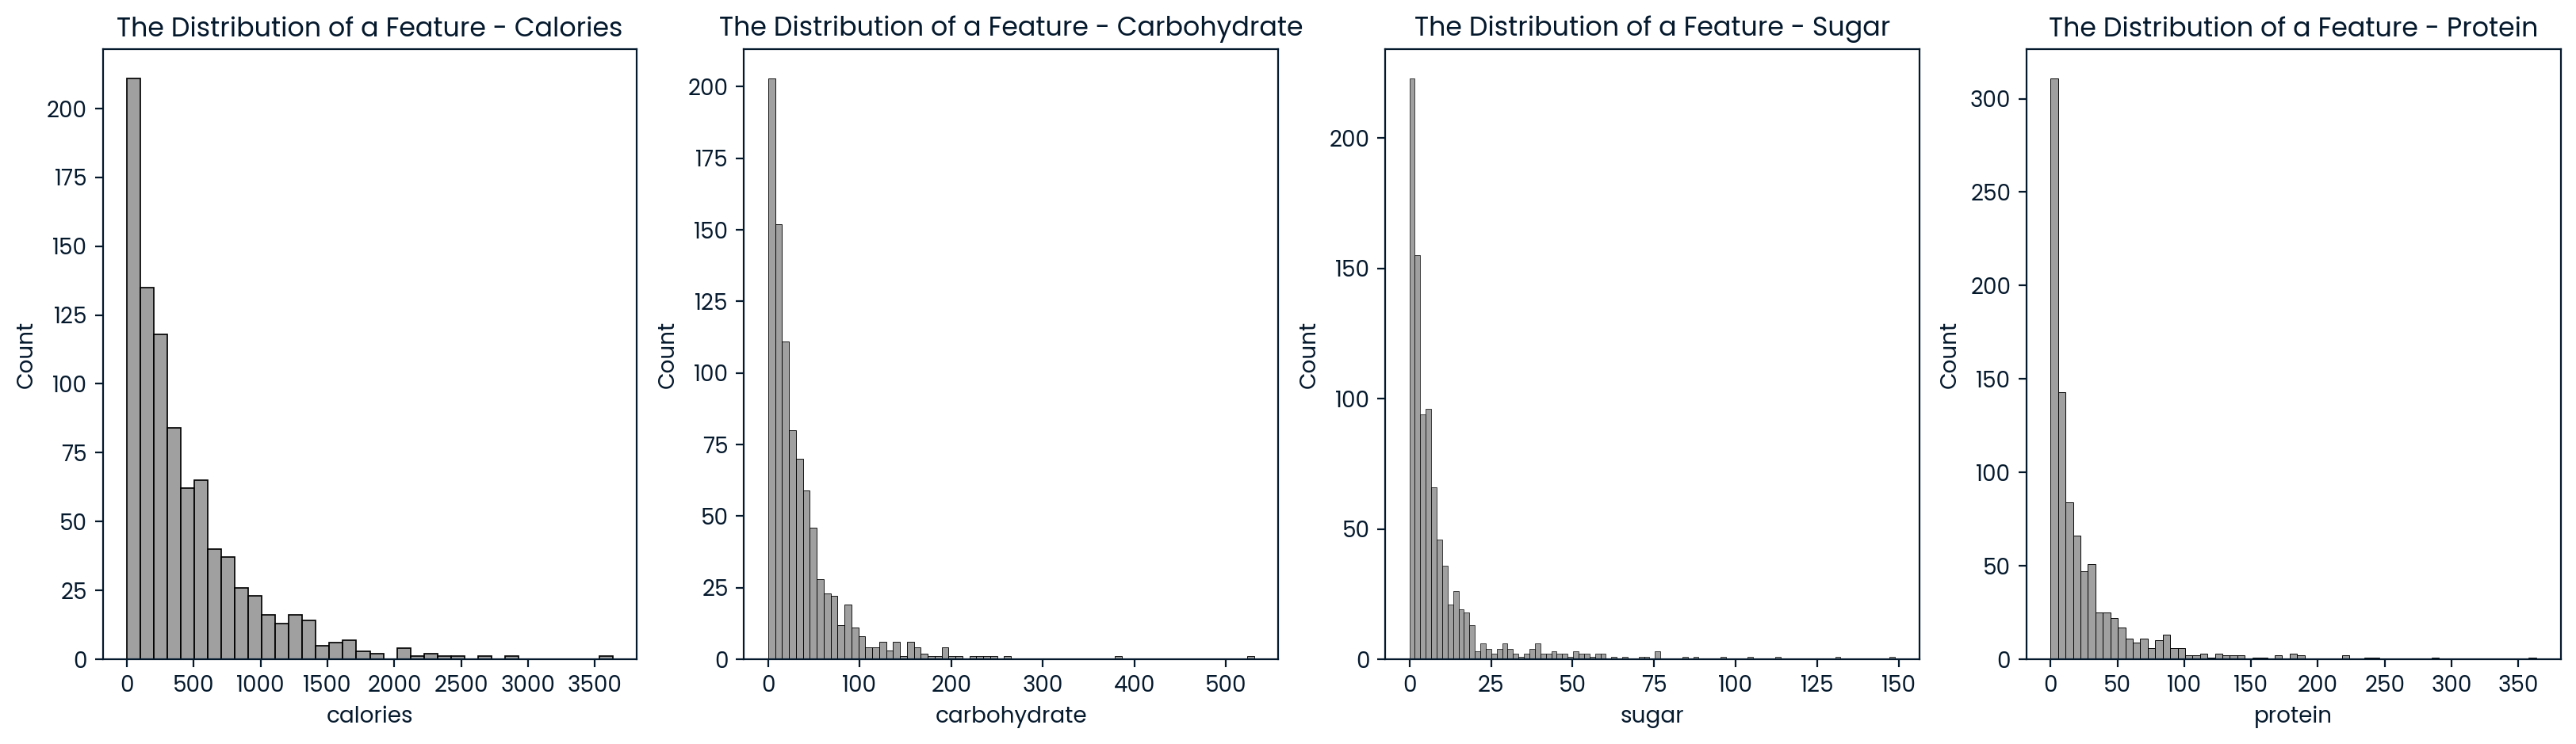

In [159]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
sns.histplot(df_clean['calories'],color='gray', ax=axes[0]).set(title='The Distribution of a Feature - Calories')
sns.histplot(df_clean['carbohydrate'],color='gray', ax=axes[1]).set(title='The Distribution of a Feature - Carbohydrate')
sns.histplot(df_clean['sugar'],color='gray', ax=axes[2]).set(title='The Distribution of a Feature - Sugar')
sns.histplot(df_clean['protein'],color='gray', ax=axes[3]).set(title='The Distribution of a Feature - Protein');

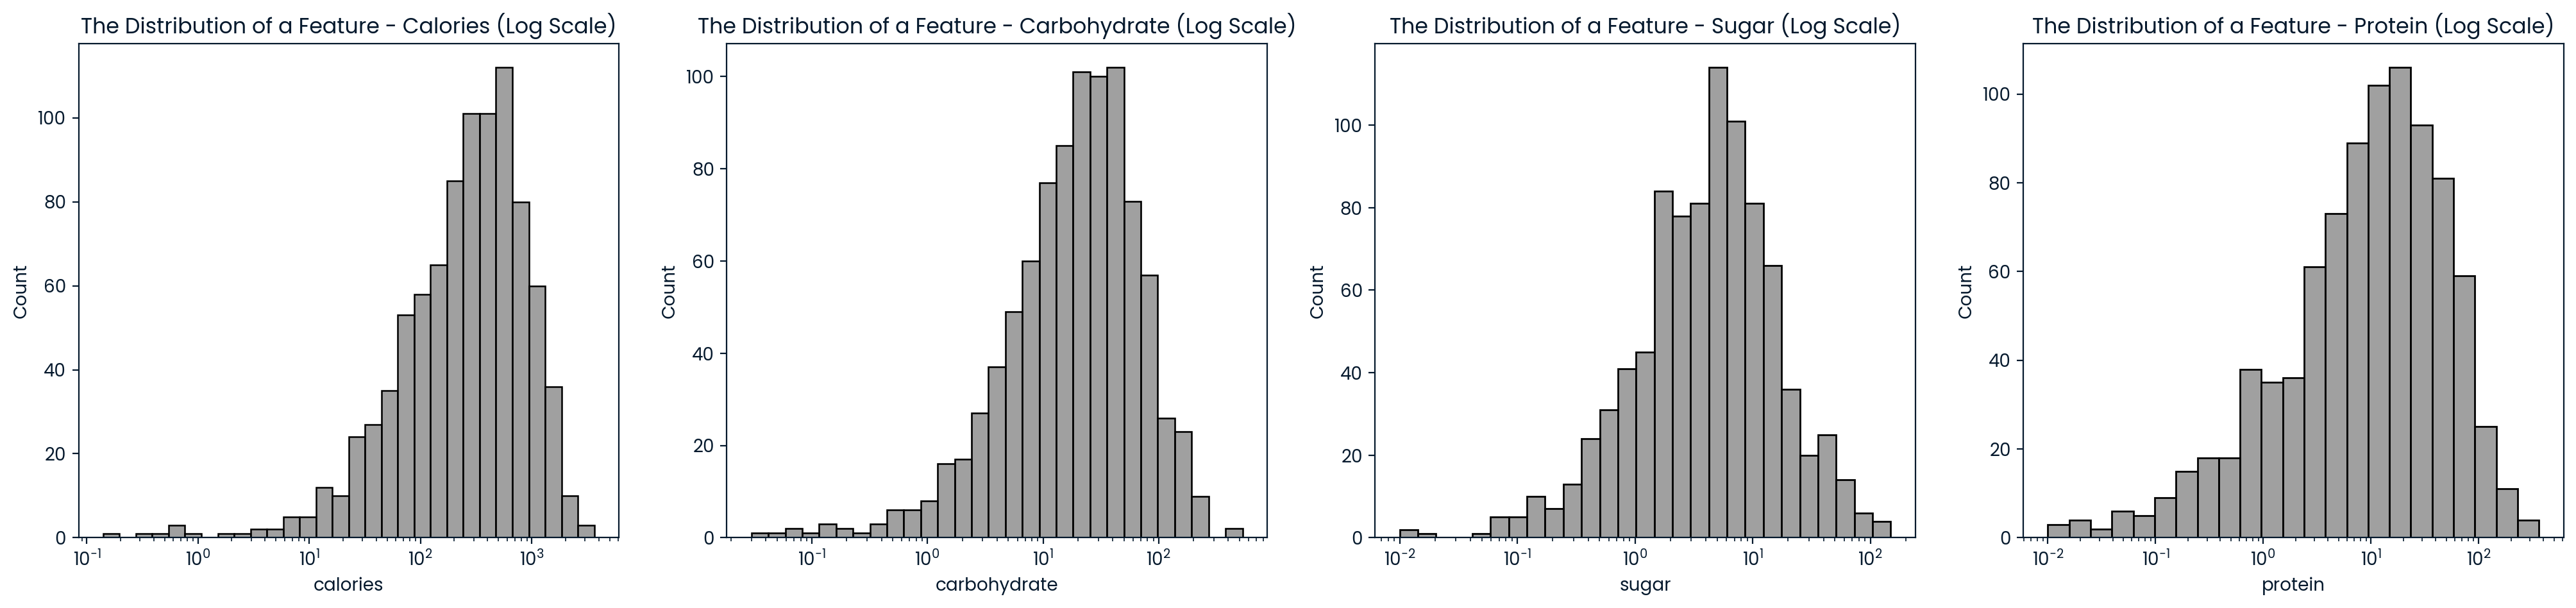

In [160]:
fig, axes = plt.subplots(1,4,figsize=(25,5))
sns.histplot(df_clean['calories'],log_scale=True,color='gray', ax=axes[0]).set(title='The Distribution of a Feature - Calories (Log Scale)')
sns.histplot(df_clean['carbohydrate'],log_scale=True,color='gray', ax=axes[1]).set(title='The Distribution of a Feature - Carbohydrate (Log Scale)')
sns.histplot(df_clean['sugar'],log_scale=True,color='gray', ax=axes[2]).set(title='The Distribution of a Feature - Sugar (Log Scale)')
sns.histplot(df_clean['protein'],log_scale=True,color='gray', ax=axes[3]).set(title='The Distribution of a Feature - Protein (Log Scale)');

### Category Popularity Distribution
From the bar charts below, we can see the most frequent categories in the dataset. 

Potato, Vegetable, and Pork recipes generate the highest traffic, while Beverages, Breakfast and Chicken recipes attract significantly fewer visitors.

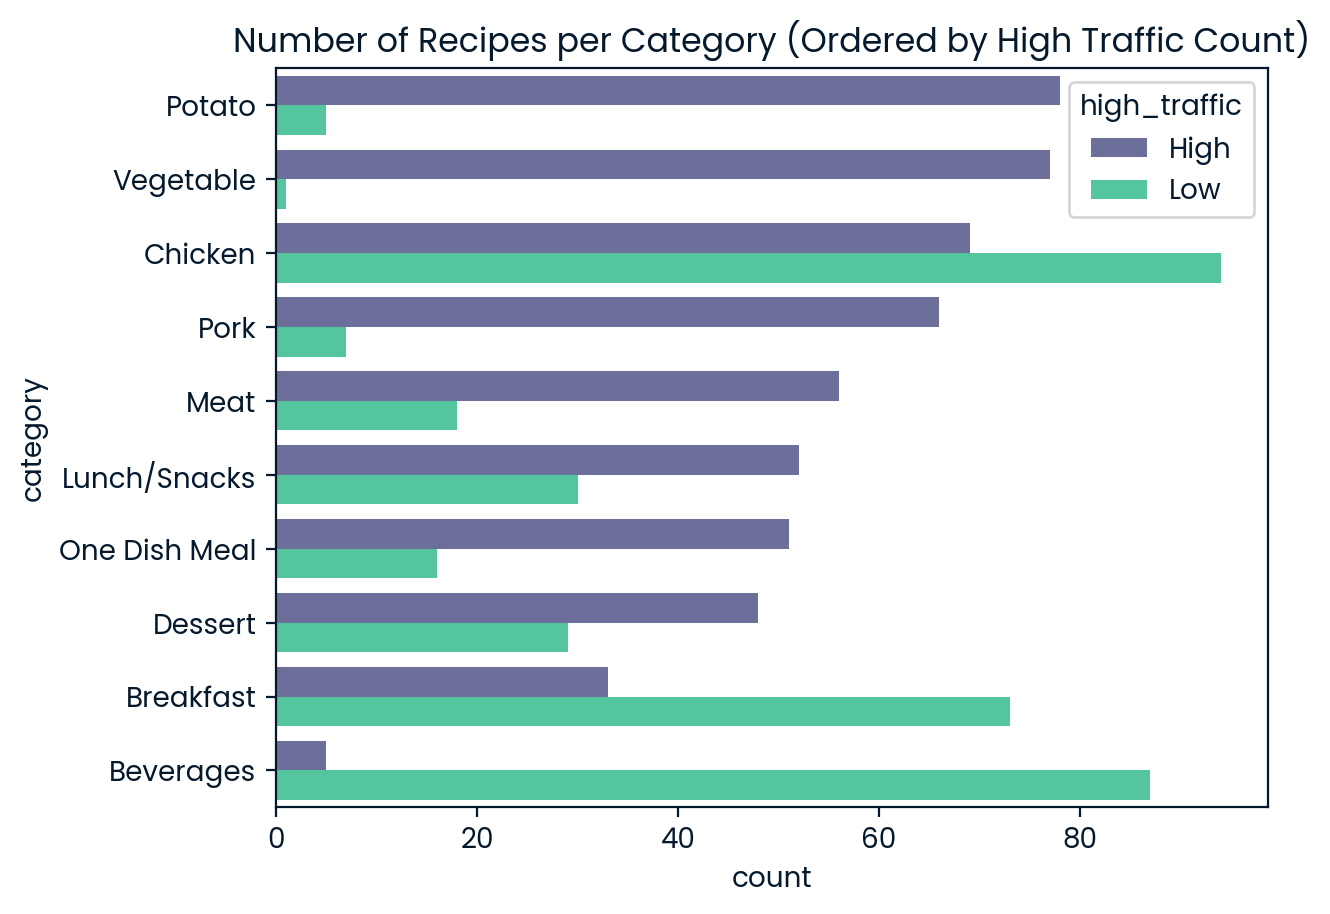

In [161]:
# Calculate the count of high-traffic recipes per category
high_traffic_counts = df_clean[df_clean['high_traffic'] == 'High']['category'].value_counts()

# Get the order (sorted by high-traffic count, highest first)
order = high_traffic_counts.index

# Plot with hue='high_traffic' and ordered by high-traffic count
sns.countplot(
    y='category',
    hue='high_traffic',
    data=df_clean,
    order=order
).set(title='Number of Recipes per Category (Ordered by High Traffic Count)')

plt.show()

### Numeric Variables – Calories, Protein, Carbohydrate, Sugar
From the heatmap and scatter plots, we observe:

- A moderate positive correlation between calories and protein (high-protein recipes tend to be higher in calories).
- A weak negative relationship between protein and sugar (protein-rich recipes often have less sugar).
- Carbohydrate and sugar show a strong positive link, as expected (sugary recipes are high in carbs).

This suggests that nutritional balance (high-protein, low-sugar) may influence traffic.

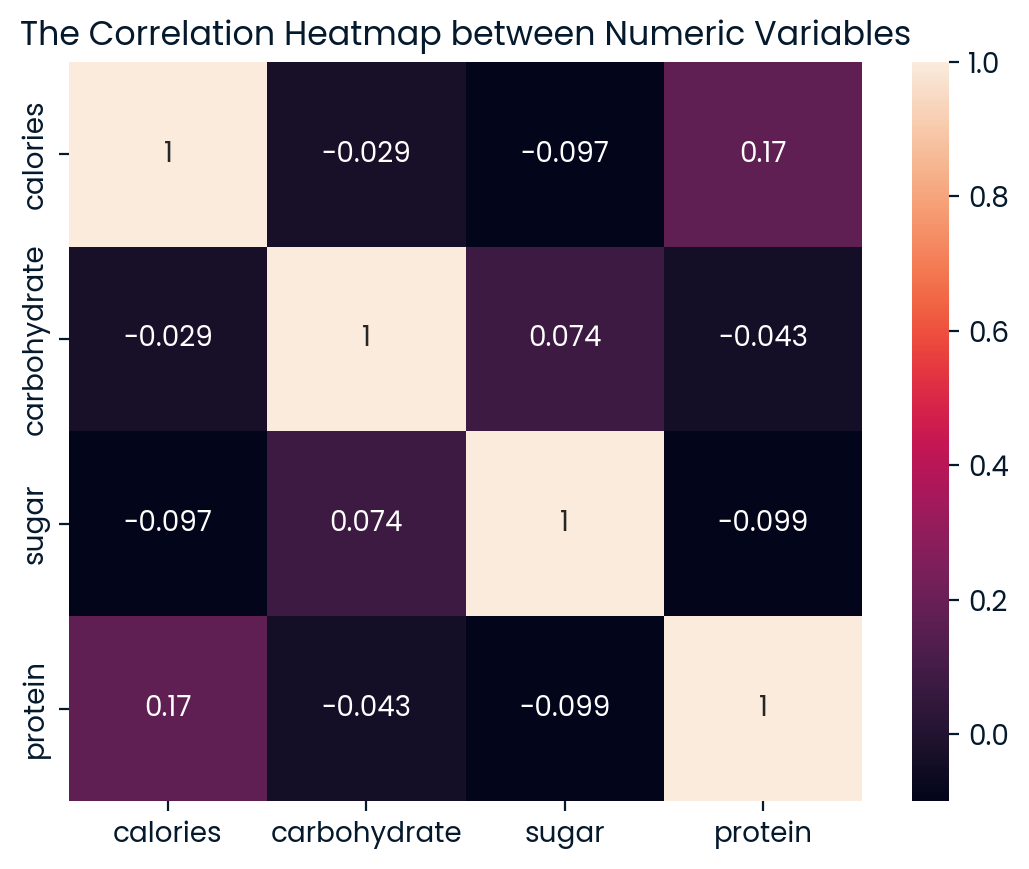

In [162]:
nutrition_cols = df_clean[['calories', 'carbohydrate', 'sugar', 'protein']]
sns.heatmap(nutrition_cols.corr(),annot=True).set(title='The Correlation Heatmap between Numeric Variables');

#### 80th Percentile Values for High-Traffic Recipes
The 80th percentile values for high-traffic recipes indicate the nutritional thresholds below which 80% of popular recipes fall. This helps identify the optimal range for maximizing traffic.

The table below shows that 80% of high-traffic recipes contain no more than 728 calories, 55g carbohydrates, 10g sugar, and 38g protein per serving, suggesting users prefer moderately balanced, lower-sugar meal options.

80th Percentile Values for High-Traffic Recipes:
calories        728.632
carbohydrate     55.592
sugar            10.342
protein          38.196
Name: 0.8, dtype: float64


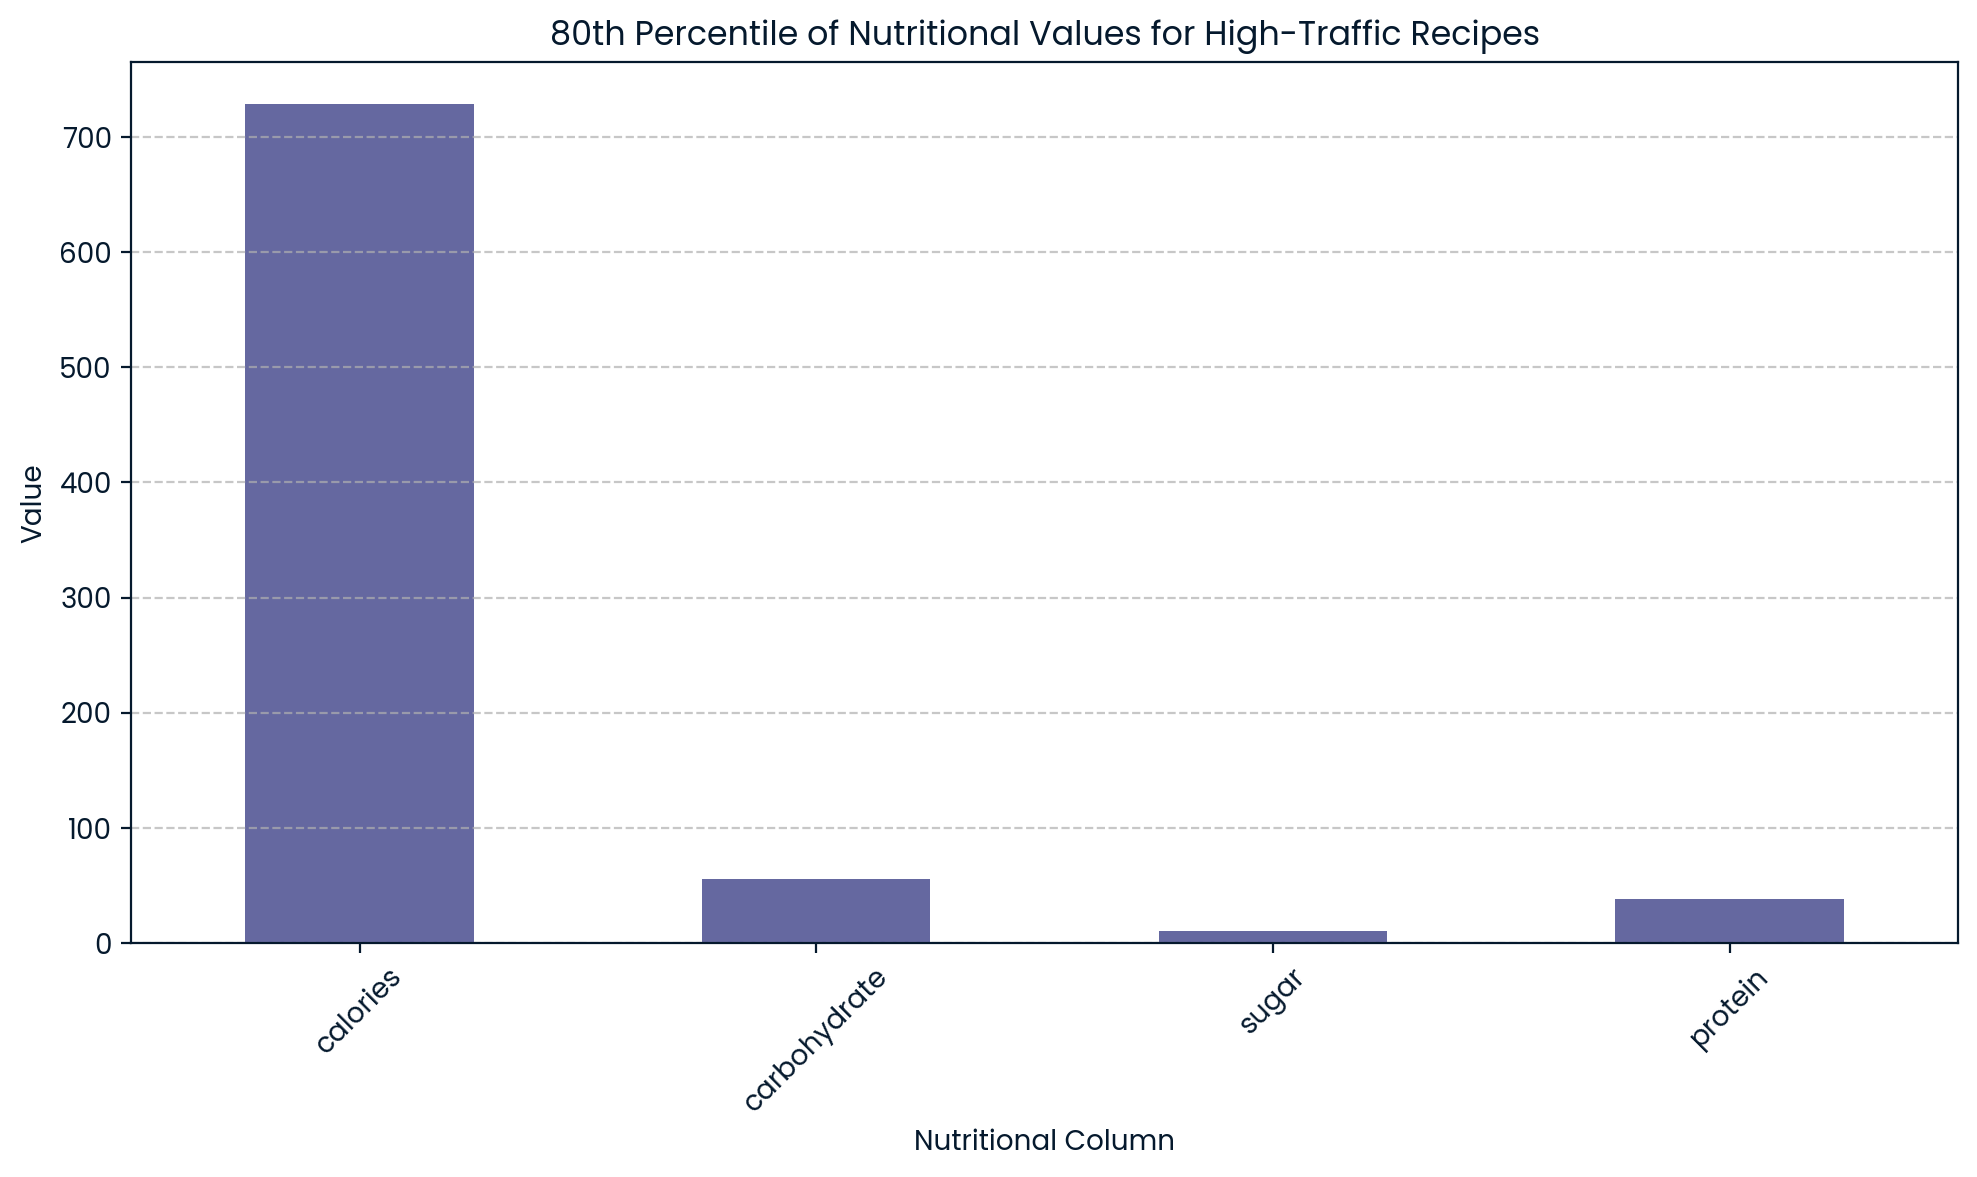

In [163]:
# Filter high-traffic recipes
high_traffic_df = df_clean[df_clean['high_traffic'] == 'High']

# Define nutritional columns
nutrition_cols = ['calories', 'carbohydrate', 'sugar', 'protein']

# Calculate the 80th percentile for each nutritional column
percentile_80 = high_traffic_df[nutrition_cols].quantile(0.8)

# Display the results
print("80th Percentile Values for High-Traffic Recipes:")
print(percentile_80)

# Visualization
plt.figure(figsize=(10, 6))
percentile_80.plot(kind='bar')
plt.title('80th Percentile of Nutritional Values for High-Traffic Recipes')
plt.ylabel('Value')
plt.xlabel('Nutritional Column')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Relationship Between Calories, Protein, Carbohydrate, Sugar, and High Traffic
I made scatterplots to see how calories, protein, carbohydrate, and sugar relate to popular (high-traffic) recipes.

Protein vs. Calories:
- Popular recipes with high protein usually have moderate calories (less than or equal to 728), meaning people like protein-rich but balanced meals.

Carbohydrate vs. Sugar:
- Recipes with higher carbs can still be popular if the sugar is low (10g or less), showing a preference for low-sugar options.

Calories vs. Carbohydrate:
- Successful recipes tend to keep calories under 728 and carbs under 55g, while also keeping sugar low.

Key takeaway: People prefer recipes that are moderate in calories, high in protein, low in sugar, and have controlled carbs.

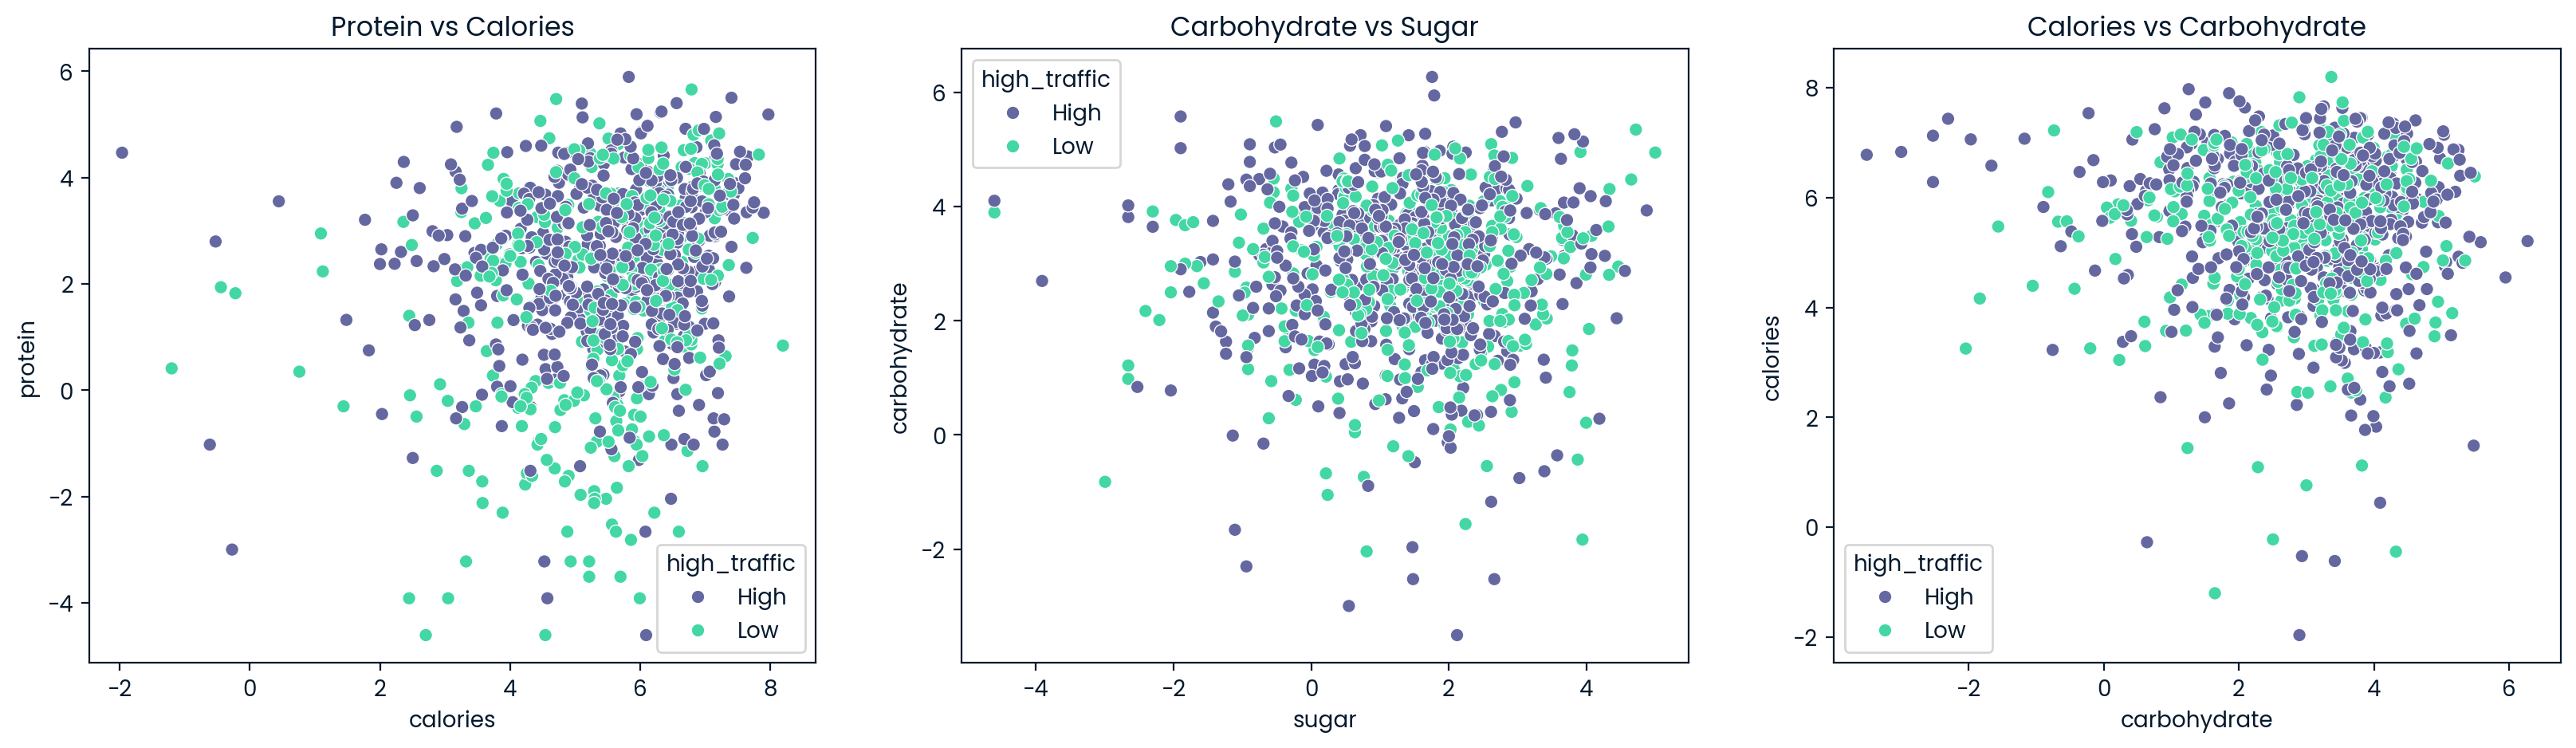

In [164]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.scatterplot(y=np.log(df_clean['protein']),x=np.log(df_clean['calories']),hue=df_clean['high_traffic'],ax=axes[0]).set(title='Protein vs Calories')
sns.scatterplot(y=np.log(df_clean['carbohydrate']),x=np.log(df_clean['sugar']),hue=df_clean['high_traffic'],ax=axes[1]).set(title='Carbohydrate vs Sugar')
sns.scatterplot(y=np.log(df_clean['calories']),x=np.log(df_clean['carbohydrate']),hue=df_clean['high_traffic'],ax=axes[2]).set(title='Calories vs Carbohydrate');

## Model Fitting & Evaluation
The task at hand is a binary classification problem aimed at predicting whether a recipe will generate high or low traffic, based on its nutritional features and categories. I have chosen Logistic Regression as the primary model due to its ability to provide interpretable coefficients, which allow us to validate insights from exploratory data analysis (EDA).

For comparison, I am using the Random Forest model, which is better at capturing non-linear relationships and interactions between features.

Evaluation Metrics:
For this classification problem, I used three metrics to check how well the model works:

- Precision: How many of the recipes the model said were popular actually are.
- Recall: How many of the truly popular recipes the model was able to find.
- F1-Score: A mix of precision and recall that gives a balanced result.

All three scores go from 0 to 1. The closer the number is to 1, the better the model is doing.
These metrics help us see how well the model predicts which recipes will get a lot of traffic.

### Prepare Data for Modelling
To enable modelling, we chose calories, carbohydrate, sugar, protein, category and servings as features, high_traffic as target variables. I also have made the following changes:

- Normalize the numeric features
- Convert the categorical variables into numeric features
- Split the data into a training set and a test set

In [165]:
# Convert target variable to binary (1 for High, 0 for not High)
df_clean['high_traffic'] = df_clean['high_traffic'].apply(lambda x: 1 if x == 'High' else 0)

print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 1 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        895 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      895 non-null    object 
 6   servings      895 non-null    int64  
 7   high_traffic  895 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 62.9+ KB
None


In [166]:
feature_cols = ["calories", "carbohydrate", "sugar", "protein", "servings"]
drop_col = ['recipe', 'high_traffic']
# Separate features and target
X = df_clean.drop(drop_col, axis=1)
y = df_clean['high_traffic']

# define the scaler, transform the skew data into normal distribution
scaler = StandardScaler()
# fit and transform the train set
X[feature_cols] = scaler.fit_transform(X[feature_cols])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [167]:
# Label the category column
encode = LabelEncoder()
X_train['category'] = encode.fit_transform(X_train['category'])
X_test['category'] = encode.transform(X_test['category'])

# The category after label encoder
label_category = dict(zip(encode.classes_,range(len(encode.classes_))))
label_category

{'Beverages': 0,
 'Breakfast': 1,
 'Chicken': 2,
 'Dessert': 3,
 'Lunch/Snacks': 4,
 'Meat': 5,
 'One Dish Meal': 6,
 'Pork': 7,
 'Potato': 8,
 'Vegetable': 9}

### Logistic Regression Model

In [168]:
# Create a Logistic Regression model
lr = LogisticRegression()

# Define hyperparameter grid for Logistic Regression
grid_lr = {'C':np.logspace(-3,3,7),                 
           'penalty':['l1','l2','elasticnet',None],  
           'multi_class':['auto','ovr','multinomial']} 
    
    # C: inverse of regularization strength 
    # penalty: regularization penalty to be used
    # multi_class: strategy for handling multiple classes
    
# Perform GridSearchCV with 10 folds
lr_cv = GridSearchCV(lr, param_grid=grid_lr,cv=10)

# Fit the model with training data
lr_cv.fit(X_train,y_train)

# Print the best parameters:
print('Tuning hyperparameters for Logistic Regression: ',lr_cv.best_params_)

Tuning hyperparameters for Logistic Regression:  {'C': 0.001, 'multi_class': 'multinomial', 'penalty': 'l2'}


In [169]:
# Create a Logistic Regression model with the hyperparameters founded:
lr_tuning = LogisticRegression(C = 10.0, multi_class = 'auto', penalty='l2')

# Fit and predict with the model
lr_tuning.fit(X_train,y_train)
y_pred_lr = lr_tuning.predict(X_test)

# Print Results
print("Logistic Regression:")

# Confusion matrix of Logistic Regression:
print('Confusion matrix of Baseline model - Logistic Regression:')
print(confusion_matrix(y_test,y_pred_lr))
print('\n')

# Classification report of Logistic Regression:
print('Classification report of Baseline model - Logistic Regression: ')
print(classification_report(y_test,y_pred_lr))

Logistic Regression:
Confusion matrix of Baseline model - Logistic Regression:
[[ 79  32]
 [ 30 128]]


Classification report of Baseline model - Logistic Regression: 
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       111
           1       0.80      0.81      0.81       158

    accuracy                           0.77       269
   macro avg       0.76      0.76      0.76       269
weighted avg       0.77      0.77      0.77       269



Our main goal is to identify high-traffic recipes, which are labeled as 1 after preprocessing. Therefore, we focus on the precision, recall, and F1-score for this class.

Logistic Regression achieved a precision of 0.80, a recall of 0.81, and an F1-score of 0.81 for predicting high-traffic recipes.

#### Finding the feature importance

Feature Importance Table:
        Feature  Importance
4      category    0.560866
1  carbohydrate    0.132716
3       protein    0.077253
5      servings    0.034182
0      calories    0.015066
2         sugar   -0.028961


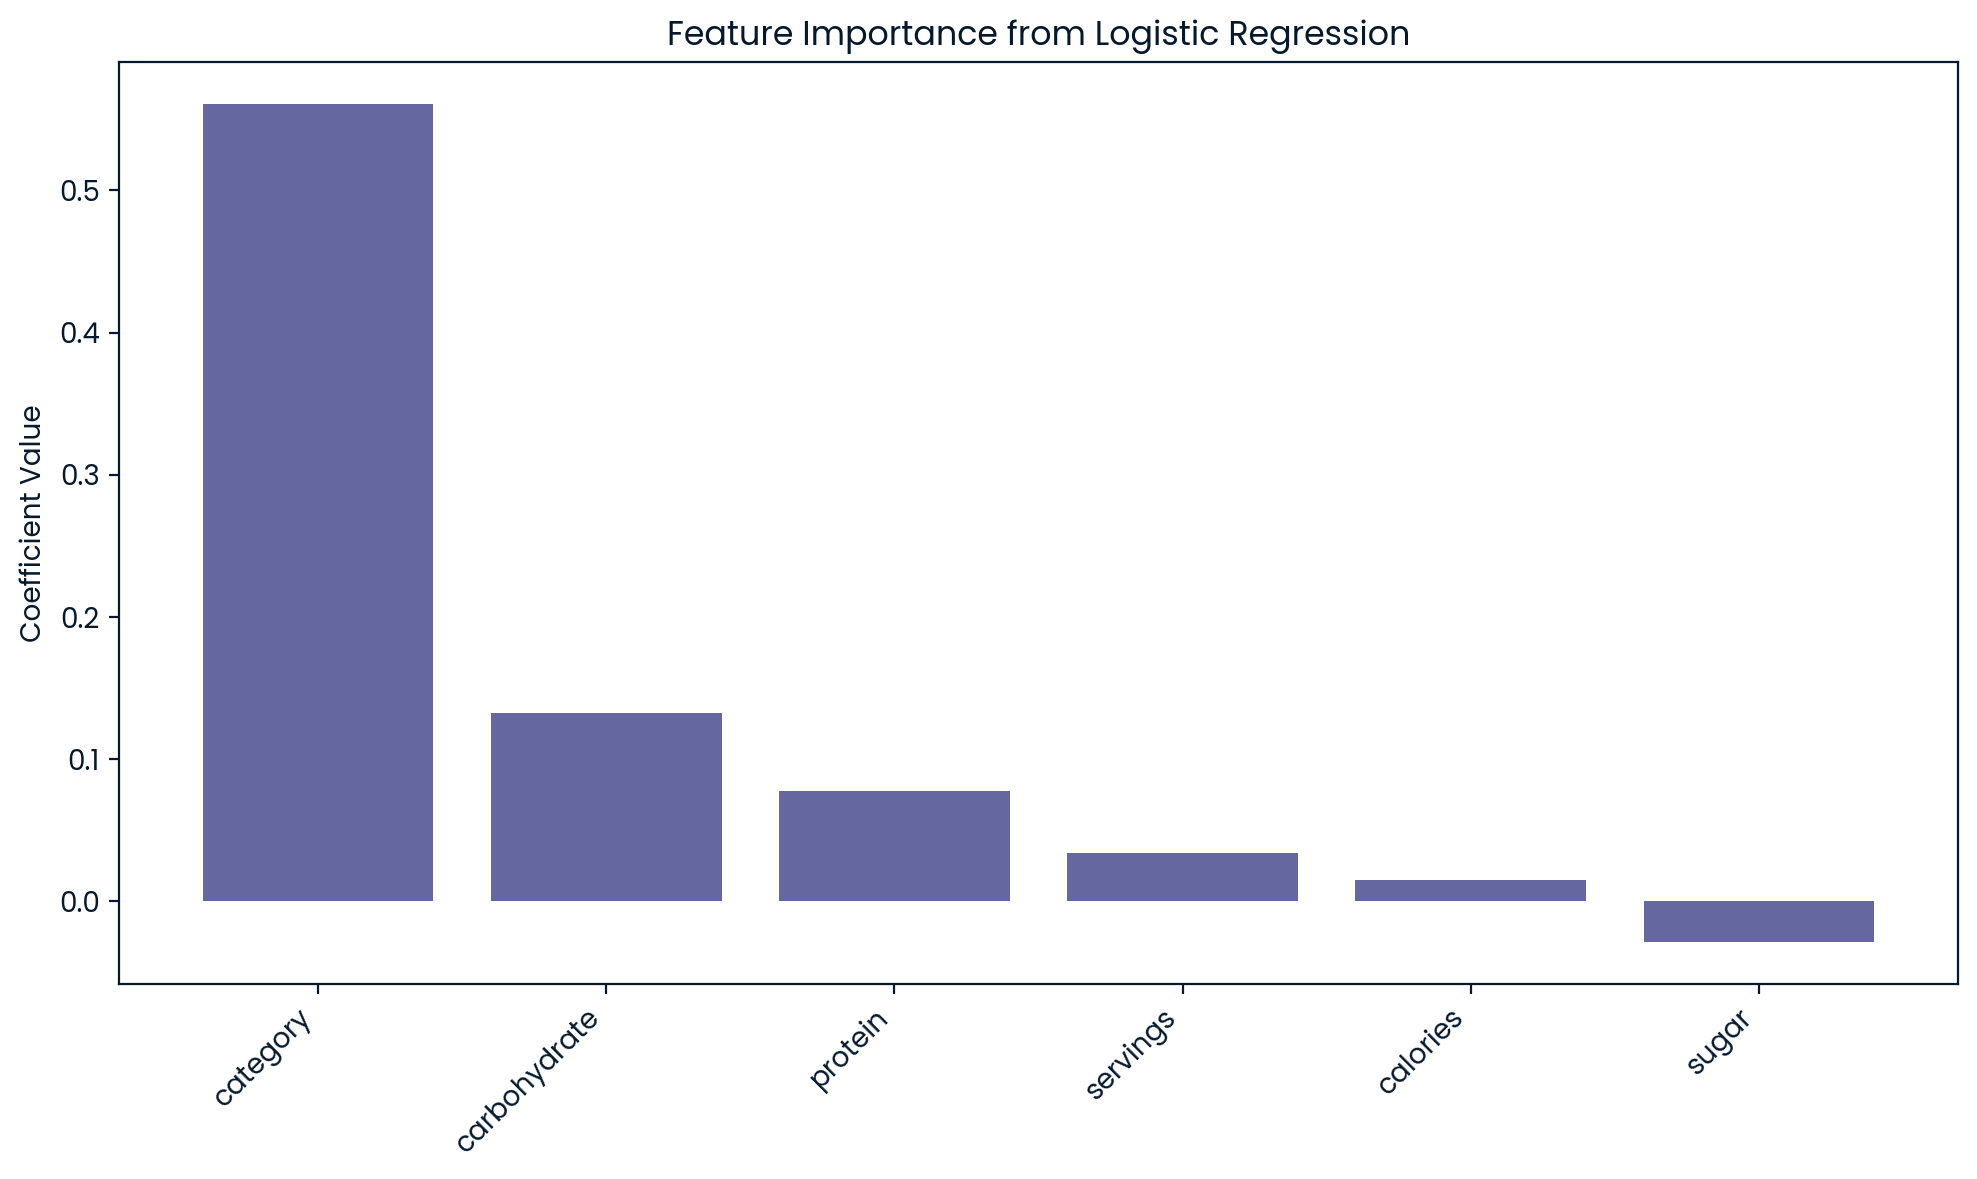

In [170]:
# Get feature importance (coefficients)
importance_lr = lr_tuning.coef_[0]

# Create a DataFrame for visualization
feature_importance_lr = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_lr
}).sort_values('Importance', ascending=False)

# Display the table
print("Feature Importance Table:")
print(feature_importance_lr)

# Simple bar plot
plt.figure(figsize=(10,6))
plt.bar(feature_importance_lr['Feature'], feature_importance_lr['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance from Logistic Regression')
plt.ylabel('Coefficient Value')
plt.tight_layout()
plt.show()

### Random Forest Classifier

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Create a Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for Random Forest
grid_rf = {
    'n_estimators': [50, 100],       # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of the trees
    'min_samples_split': [2, 5],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2]         # Minimum samples required at each leaf node
}

# Perform GridSearchCV with 10 folds
rf_cv = GridSearchCV(rf, param_grid=grid_rf, cv=10)

# Fit the model with training data
rf_cv.fit(X_train, y_train)

# Print the best parameters:
print('Tuning hyperparameters for Random Forest: ', rf_cv.best_params_)

Tuning hyperparameters for Random Forest:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [172]:
# Create a Random Forest Classifier model with the hyperparameters founded:
rf_tuning = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=2, min_samples_split=2, random_state=42)

# Fit and predict with the model
rf_tuning.fit(X_train, y_train)
y_pred_rf = rf_tuning.predict(X_test)

# Print Results
print("Random Forest Classifier:")

# Confusion matrix of Logistic Regression:
print('Confusion matrix of Baseline model - Random Forest Classifier:')
print(confusion_matrix(y_test,y_pred_rf))
print('\n')

# Classification report of Logistic Regression:
print('Classification report of Baseline model - Random Forest Classifier: ')
print(classification_report(y_test,y_pred_rf))

Random Forest Classifier:
Confusion matrix of Baseline model - Random Forest Classifier:
[[ 62  49]
 [ 26 132]]


Classification report of Baseline model - Random Forest Classifier: 
              precision    recall  f1-score   support

           0       0.70      0.56      0.62       111
           1       0.73      0.84      0.78       158

    accuracy                           0.72       269
   macro avg       0.72      0.70      0.70       269
weighted avg       0.72      0.72      0.71       269



Random Forest Classifier achieved a precision of 0.73, a recall of 0.84, and an F1-score of 0.78 for predicting high-traffic recipes.

#### Finding the feature importance

Feature Importance Table:
        Feature  Importance
4      category    0.386284
3       protein    0.189288
0      calories    0.133616
2         sugar    0.128945
1  carbohydrate    0.123310
5      servings    0.038557


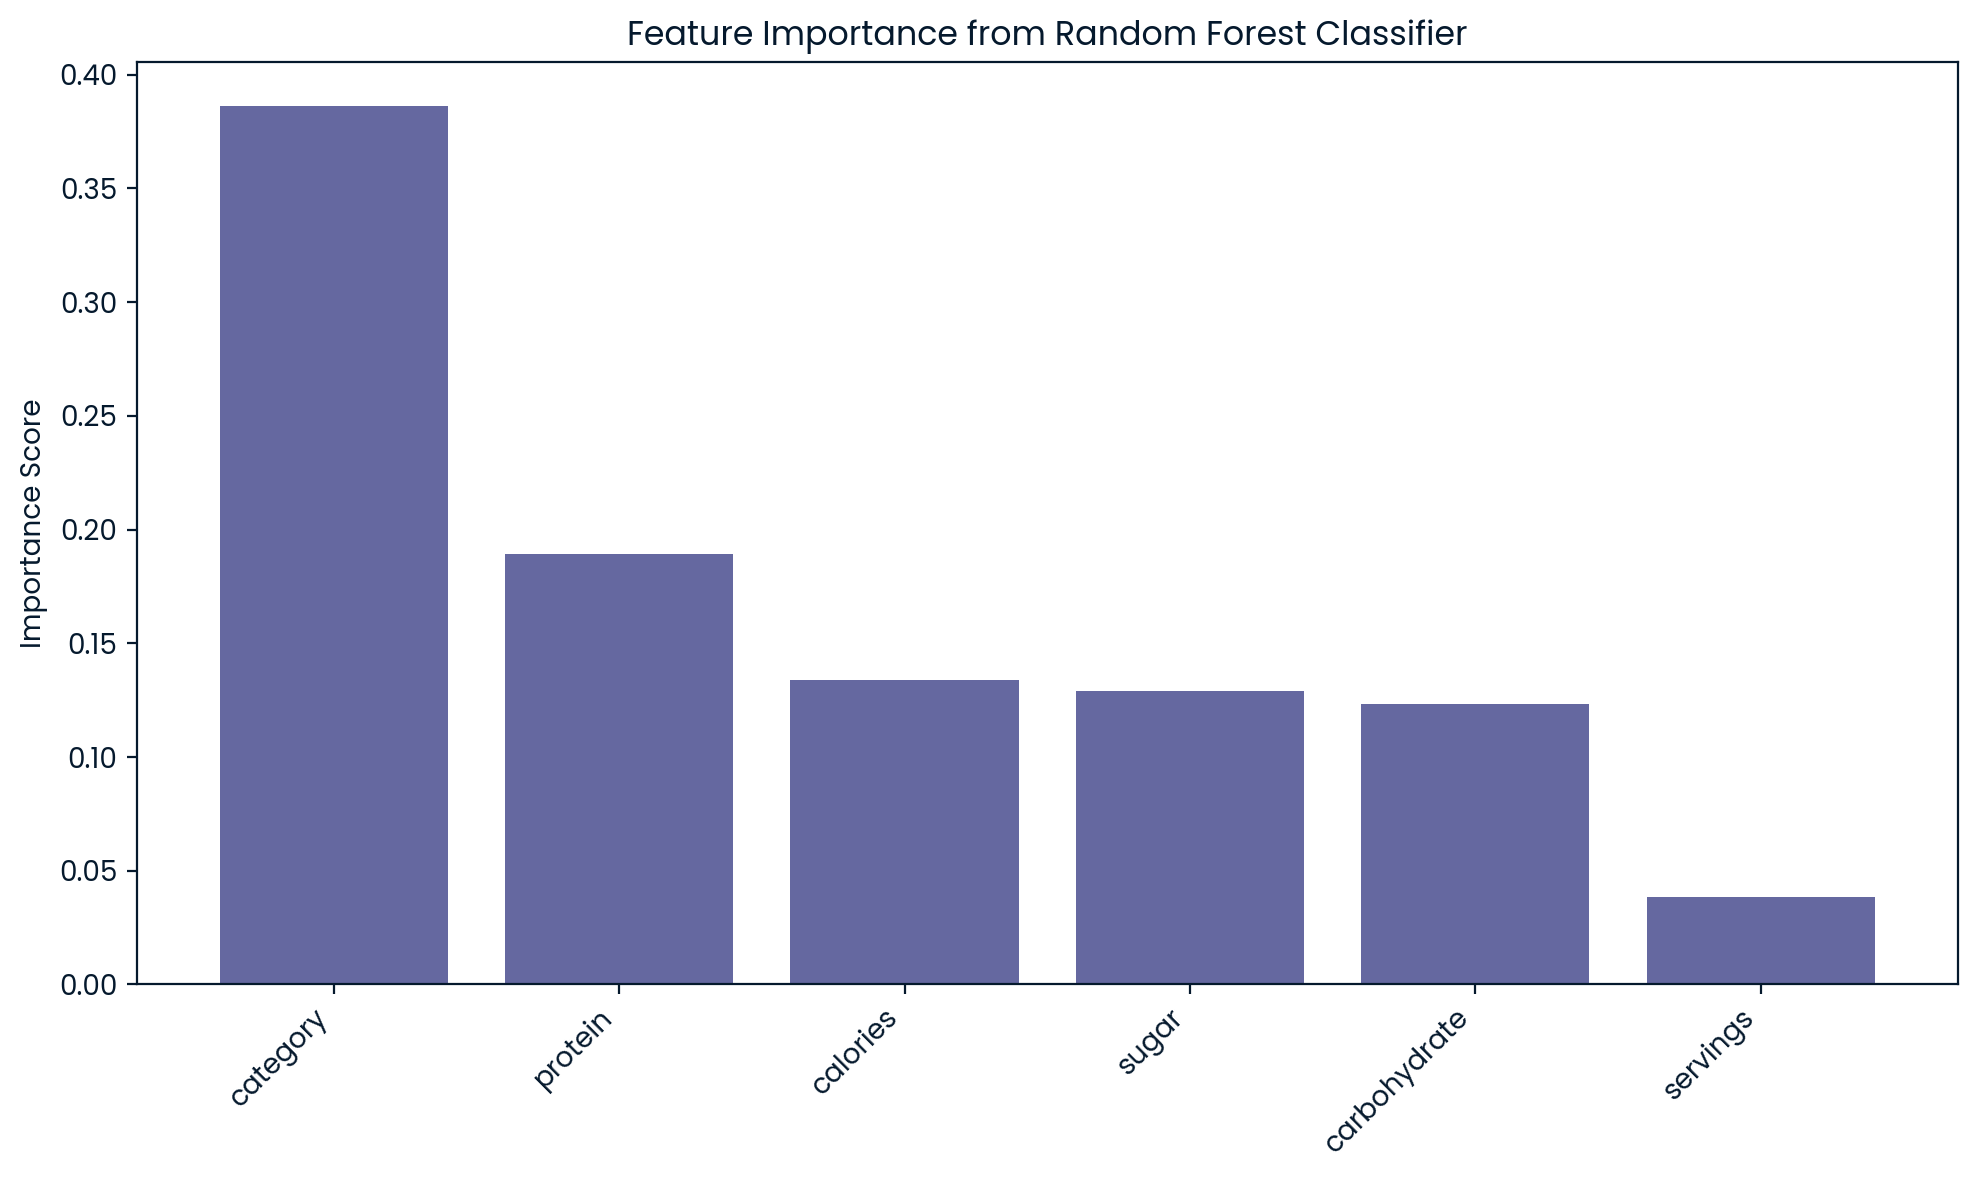

In [173]:
# Get feature importance from Random Forest
importance_rf = rf_tuning.feature_importances_  

# Create a DataFrame for visualization
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_rf
}).sort_values('Importance', ascending=False)

# Display the table
print("Feature Importance Table:")
print(feature_importance_rf)

# Simple bar plot
plt.figure(figsize=(10,6))
plt.bar(feature_importance_rf['Feature'], feature_importance_rf['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance from Random Forest Classifier')
plt.ylabel('Importance Score')  # Changed from 'Coefficient Value'
plt.tight_layout()
plt.show()

## Results
After testing both models, Logistic Regression achieved an F1-score of 0.81, while the Random Forest Classifier scored 0.78. This indicates that Logistic Regression provides a better balance between precision and recall in this case, making it the more effective model for handling the dataset.

#### Evaluate by business idea
The company wants to correctly predict high-traffic recipes at least 80% of the time. Logistic Regression achieved 77% accuracy, and Random Forest reached 72% accuracy. Since only Logistic Regression is close to the target, it is the better choice for deployment.

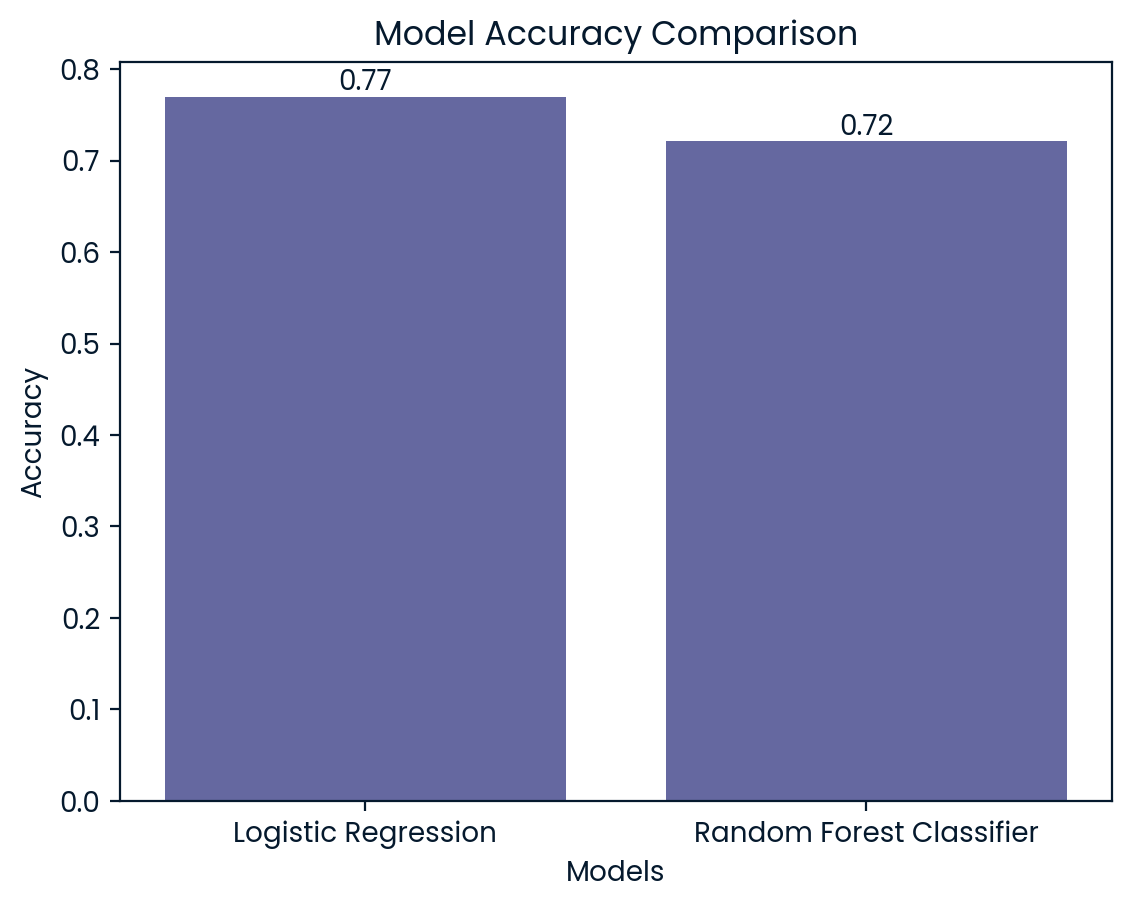

In [174]:
# Accuracy score of Logistic Regression:
accuracy_lr = accuracy_score(y_test,y_pred_lr)

# Accuracy score of LinearSVC:
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Model names and their accuracy scores
models = ['Logistic Regression', 'Random Forest Classifier']
accuracy_scores = [accuracy_lr, accuracy_rf]

# Create a bar chart
plt.bar(models, accuracy_scores)

# Label the axes
plt.xlabel('Models')
plt.ylabel('Accuracy')

# Show the accuracy value on top of each bar
for i, score in enumerate(accuracy_scores):
    plt.text(i, score, f'{score:.2f}', ha='center', va='bottom')

# Add a title to the chart
plt.title('Model Accuracy Comparison')

# Display the plot
plt.show()

#### Recommendation

1. Promote Popular Categories

   - Recipes with Potato, Vegetable, and Pork are the most viewed. We should feature these more on the homepage and in marketing content.

2. Improve Underperforming Recipes

   - Beverage, Breakfast, and Chicken recipes aren’t doing as well. To boost performance, we should:

   - Align their nutrition with popular recipes: around 728 calories, ≤10g sugar, and \~38g protein.

3. Leverage Predictive Modeling

   - The Logistic Regression model (77% accuracy) can help us:

   - Predict which new recipes are likely to attract high traffic before publishing.
   - Focus on nutrient combinations that drive popularity—like \~55g carbs and \~38g protein.

Next Steps:
Start testing these changes gradually and monitor the results every few months to see what works best.